In [1]:
import segyio
from __future__ import print_function
import os
import sys
import time
from obspy.io.segy.segy import _read_segy, SEGYBinaryFileHeader
from obspy import read
import numpy as np

os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # Only GPU 1 is visible to this code

In [2]:
filename = '/data/anyu/data/OilData/TrainingData/P00675589/FILE_000001.sgy'

# Read use _read_segy()

In [3]:
t0=time.time()
segy = _read_segy(filename)
print('--> data read in {:.1f} sec'.format(time.time()-t0))

KeyboardInterrupt: 

In [ ]:
binary_file_header = segy.binary_file_header
print("\nbinary_file_header:\n", binary_file_header)

textual_file_header = segy.textual_file_header
print("\ntextual_file_header:\n", textual_file_header)

data_encoding=segy.data_encoding
print("\ndata_encoding:\n",data_encoding)
endian=segy.endian
print("\nendian:\n", endian)
file=segy.file
print("\nfile:\n", file)
classinfo = segy.__class__
print("\nclassinfo:\n", classinfo)
doc = segy.__doc__
print("\ndoc:\n", doc)
ntraces=len(segy.traces)
print("\nntraces:\n", ntraces)
size_M=segy.traces[0].data.nbytes/1024/1024.*ntraces
print("\nsize:\n\t", size_M,"MB")
print("\t", size_M/1024, "GB")

# Read use read()

In [ ]:
t0=time.time()
print('sgy use read:')
stream = read(filename)
print('--> data read in {:.1f} min'.format((time.time()-t0)/60))

In [ ]:
print(stream)

In [ ]:
il=[]
xl=[]
for i in range(len(stream)):
    trace_i_header = stream[i].stats.segy.trace_header
    il.append(trace_i_header.original_field_record_number)
    xl.append(trace_i_header.ensemble_number)
# print(il)
# print(xl)
    

In [ ]:
print(il)

In [ ]:
print(xl)

In [ ]:
for i in range(0,1597,1): 
    print("---------------------")
    trace_i_header = stream[i].stats.segy.trace_header
    print("trace_sequence_number_within_line", trace_i_header.trace_sequence_number_within_line)
    print("original_field_record_number", trace_i_header.original_field_record_number)
    print("ensemble_number", trace_i_header.ensemble_number)

In [ ]:
for i in range(0,len(stream),1596):
    print("---------------------")
    trace_i_header = stream[i].stats.segy.trace_header
    print("trace_sequence_number_within_line", trace_i_header.trace_sequence_number_within_line)
    print("original_field_record_number", trace_i_header.original_field_record_number)
    print("ensemble_number", trace_i_header.ensemble_number)

In [ ]:
ilines = np.unique(il)
print(ilines)
print(len(ilines))

In [ ]:
xlines = np.unique(xl)
print(xlines)
print(len(xlines))

Output shows this is not a cube. use counter to see how many samples in each crossline or inline

In [ ]:
from collections import Counter
t0=time.time()
counter = Counter(il)
print('Count in {:.1f} sec'.format(time.time()-t0))
print (sorted(counter.items()))

In [ ]:
from collections import Counter
t0=time.time()
counter = Counter(xl)
print('Count in {:.1f} sec'.format(time.time()-t0))
print (sorted(counter.items()))

In [ ]:
print(counter)

results shows that crossline from 860 to 2449 have full 1807 inline samples. inline from 1001 to 2807. These numbers can be used to cut a cube out of this non cube 3d sgy file.

In [17]:
from obspy import read, Trace, Stream, UTCDateTime
from obspy.core import AttribDict
from obspy.io.segy.segy import SEGYTraceHeader, SEGYBinaryFileHeader
from obspy.io.segy.core import _read_segy
import numpy as np
import sys
import math

st = Stream()
j = 1
for i in range(len(stream)):
    # Create some random data.

#     if 1001<=il[i]<=2807 and 860<=xl[i]<=2449:
    if 1001<=il[i]<=1139 and 860<=xl[i]<=1018:
        trace = stream[i]
        trace.stats.segy.trace_header.trace_sequence_number_within_segy_file = j
        trace.stats.segy.trace_header.trace_sequence_number_within_line = math.ceil(j/139)
#         trace.stats.segy.trace_header.trace_sequence_number_within_line = math.ceil(i/1807)
        st.append(stream[i])
        j = j+1

# A SEGY file has file wide headers. This can be attached to the stream
# object.  If these are not set, they will be autocreated with default
# values.
st.stats = AttribDict()
st.stats.textual_file_header = 'Textual Header!'
st.stats.binary_file_header = SEGYBinaryFileHeader()
st.stats.binary_file_header.trace_sorting_code = 4

print ("Stream object before writing...")
print (st)

Stream object before writing...
22101 Trace(s) in Stream:

Seq. No. in line:    1 | 2007-01-01T00:00:00.000000Z - 2007-01-01T00:00:04.608000Z | 333.3 Hz, 1537 samples
...
(22099 other traces)
...
Seq. No. in line:  159 | 2007-01-01T00:00:00.000000Z - 2007-01-01T00:00:04.608000Z | 333.3 Hz, 1537 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]


In [18]:
print(st[-1].__str__(extended=True))
print("trace_sequence_number_within_segy_file", st[-1].stats.segy.trace_header.trace_sequence_number_within_segy_file)

Seq. No. in line:  159 | 2007-01-01T00:00:00.000000Z - 2007-01-01T00:00:04.608000Z | 333.3 Hz, 1537 samples
trace_sequence_number_within_segy_file 22101


In [19]:
t0=time.time()
print("start write cube.sgy")
st.write("cube.sgy", format="SEGY", data_encoding=1, textual_header_encoding = 'EBCDIC') #, byteorder=sys.byteorder
print('write in {:.1f} sec'.format(time.time()-t0))
print ("Stream object after writing. Will have some segy attributes...")
print (st)

print ("Reading using obspy.io.segy...")
t0=time.time()
st1 = _read_segy("cube.sgy")
print('_read_segy() in {:.1f} sec'.format(time.time()-t0))
print (st1)

print ("Reading using obspy.core...")
t0=time.time()
st2 = read("cube.sgy")
print('_read_segy() in {:.1f} sec'.format(time.time()-t0))
print (st2)

print ("Just to show that the values are written...")
print ([tr.stats.segy.trace_header.receiver_group_elevation for tr in st])
print ([tr.stats.segy.trace_header.receiver_group_elevation for tr in st2])
print (st.stats.binary_file_header.trace_sorting_code)
print (st1.stats.binary_file_header.trace_sorting_code)

start write cube.sgy
write in 16.7 sec
Stream object after writing. Will have some segy attributes...
22101 Trace(s) in Stream:

Seq. No. in line:    1 | 2007-01-01T00:00:00.000000Z - 2007-01-01T00:00:04.608000Z | 333.3 Hz, 1537 samples
...
(22099 other traces)
...
Seq. No. in line:  159 | 2007-01-01T00:00:00.000000Z - 2007-01-01T00:00:04.608000Z | 333.3 Hz, 1537 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]
Reading using obspy.io.segy...
_read_segy() in 4.9 sec
22101 Trace(s) in Stream:

Seq. No. in line:    1 | 2007-01-01T00:00:00.000000Z - 2007-01-01T00:00:04.608000Z | 333.3 Hz, 1537 samples
...
(22099 other traces)
...
Seq. No. in line:  159 | 2007-01-01T00:00:00.000000Z - 2007-01-01T00:00:04.608000Z | 333.3 Hz, 1537 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]
Reading using obspy.core...
_read_segy() in 4.6 sec
22101 Trace(s) in Stream:

Seq. No. in line:    1 | 2007-01-01T00:00:00.000000Z - 2007-01-01T00:00:04.608000Z | 333

In [20]:
import matplotlib.pyplot as plt


t0=time.time()
segy = _read_segy("cube.sgy")
# segy = core._read_segy(filename)
print('--> data read in {:.1f} sec'.format(time.time()-t0))
ntraces=len(segy.traces)
sr=segy.stats.binary_file_header.sample_interval_in_microseconds/1e3 # sr is 3m
ns=segy.stats.binary_file_header.number_of_samples_per_data_trace
print(sr)
print(ns)
print(segy.traces[0])
print(segy.traces[-1])

size_kb=segy.traces[0].data.nbytes/1024.*ntraces
z=np.arange(0,ns*sr,sr)

# #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
inl = np.arange(1001,1140,1) #139
crl = np.arange(860,1019,1) #159
seis = np.vstack([xx.data for xx in segy.traces]).T
seis = seis.reshape(ns,inl.size,crl.size)


--> data read in 13.6 sec
3.0
1537
Seq. No. in line:    1 | 2007-01-01T00:00:00.000000Z - 2007-01-01T00:00:04.608000Z | 333.3 Hz, 1537 samples
Seq. No. in line:  159 | 2007-01-01T00:00:00.000000Z - 2007-01-01T00:00:04.608000Z | 333.3 Hz, 1537 samples


In [3]:
t0=time.time()
print('sgy use _read_segy:')
segy_big = _read_segy(filename)
print('--> data read in {:.1f} min'.format((time.time()-t0)/60))
t0=time.time()
print('sgy use read:')
stream = read(filename)
print('--> data read in {:.1f} min'.format((time.time()-t0)/60))

sgy use _read_segy:
--> data read in 5.7 min
sgy use read:


/home/anyu/anaconda3/lib/python3.6/site-packages/obspy/io/segy/segy.py:778: UserWarning: Trace starttime does not store a proper date (day of year is zero). Using January 1st 00:00 as trace start time.
  warnings.warn(msg)


--> data read in 18.3 min


In [4]:
seis_big = np.zeros((1807,3174,1537))

In [5]:
t0=time.time()
print(len(segy_big.traces))
print(len(stream))
for i in range(len(segy_big.traces)):
    tracei = stream[i]
    il=tracei.stats.segy.trace_header.original_field_record_number
    xl=tracei.stats.segy.trace_header.ensemble_number
    seis_big[il-1001][xl-851] = tracei.data
print('--> data read in {:.1f} min'.format((time.time()-t0)/60))

4398078
4398078
--> data read in 1.7 min


In [6]:
import matplotlib.pyplot as plt
# im_np = numpy.random.rand(h, w)
print(seis_big.shape)
im_np = seis_big[1]
fig = plt.figure(frameon=False)
DPI = fig.get_dpi()
print(DPI)
fig.set_size_inches(3174.0/float(DPI),1537.0/float(DPI))
# fig.set_size_inches(1807,1590)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
# ax.imshow(im_np, aspect='normal')
ax.imshow(im_np, cmap='seismic')
fig.savefig('il2.png')


(1807, 3174, 1537)
100.0


In [13]:
# plt.show()

In [12]:
print(seis_big[2].sum())

-27.61593951994085


In [7]:
t0=time.time()
print('sgy save as npy:')
np.save("seis",seis_big)
print('--> data save in {:.1f} min'.format((time.time()-t0)/60))

sgy save as npy:
--> data save in 1.1 min


In [21]:
def plot3dseis(seis,d1,d2,d3,d1_sel=None,d2_sel=None,d3_sel=None,id1='Z',id2='IL',id3='XL',cm='seismic'):
    '''
    plot3dseis (C) aadm 2016
    Plot inline, crossline or horizontal (time/depth) slice from 3D seismic volume.
    INPUT
    seis:        3D seismic cube numpy array, shape (a,b,c);
                 usually this will be (twt.size, inl.size, crl.size)
    d1, d2, d3:  numpy array containing the range of first, second and third dimension in the cube;
                 usually d1=twt, d2=inl, d3=crl are defined beforehand,
                 e.g. inl=np.arange(1000,2000,4)
    d1_sel, ...: to select one horizontal slice, one inline or on crossline
                 e.g., d2_sel=1500 to plot IL 1500 (if d2=inl); only set one, the others must be None
    id1, ...:    names for first, second, third dimensions
    cmap:        colormap to use (choose one of the matplotlib colormaps)
    '''

    if (d1_sel is None) & (d2_sel is None) & (d3_sel is None):
        d2_sel = d2[int(d2.size/2)]
    if d1_sel is not None:
        ssplot=seis[d1.tolist().index(d1_sel),:,:]
        nome1,nome2,nomex,nomey = id1,str(d1_sel),id2,id3
        xleft,xrite = d2.min(),d2.max()
        ytop,ybot   = d3.min(),d3.max()
    if d2_sel is not None:
        ssplot=seis[:,d2.tolist().index(d2_sel),:]
        nome1,nome2,nomex,nomey = id2,str(d2_sel),id3,id1
        xleft,xrite = d3.min(),d3.max()
        ytop,ybot   = d1.min(),d1.max()
    if d3_sel is not None:
        ssplot=seis[:,:,d3.tolist().index(d3_sel)]
        nome1,nome2,nomex,nomey = id3,str(d3_sel),id2,id1
        xleft,xrite = d2.min(),d2.max()
        ytop,ybot   = d1.min(),d1.max()

    print('input 3D dimensions: {}'.format(seis.shape))
    print('{0}: {1}-{2}'.format(id1, d1.min(), d1.max()))
    print('{0}: {1}-{2}'.format(id2, d2.min(), d2.max()))
    print('{0}: {1}-{2}'.format(id3, d3.min(), d3.max()))
    print('dataset to plot dimensions: {}'.format(ssplot.shape))

    plt.figure(figsize=(10,8))
    plt.imshow(ssplot,extent=[xleft,xrite,ybot,ytop],aspect='auto',cmap=cm)
    plt.colorbar(shrink=0.75), plt.grid()
    plt.tick_params(axis='both', which='major', labelsize=8)
    plt.title(nome1+' '+nome2)
    plt.xlabel(nomex), plt.ylabel(nomey)
    plt.show()
    

input 3D dimensions: (1537, 139, 159)
depth [m]: 0.0-4608.0
IL: 1001-1139
XL: 860-1018
dataset to plot dimensions: (1537, 159)


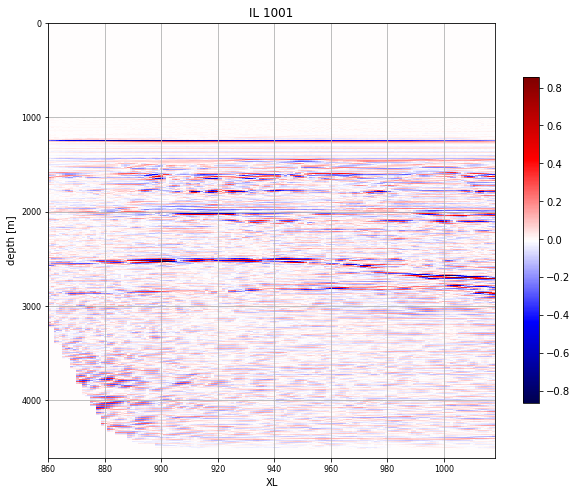

In [22]:
# #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
plot3dseis(seis,z,inl,crl,d1_sel=None,d2_sel=1001,d3_sel=None,id1='depth [m]',id2='IL',id3='XL')
# plt.ylim(15000,0),plt.clim(-150,150)
# plt.show()

In [23]:
from obspy import read, Trace, Stream, UTCDateTime
from obspy.core import AttribDict
from obspy.io.segy.segy import SEGYTraceHeader, SEGYBinaryFileHeader
from obspy.io.segy.core import _read_segy
import numpy as np
import sys
import math

stremstoplot = Stream()
j = 1
for i in range(len(stream)):
    # Create some random data.

     if 1001<=il[i]<=2807 and 860<=xl[i]<=2449:
#     if 1001<=il[i]<=1139 and 860<=xl[i]<=1018:
        trace = stream[i]
        trace.stats.segy.trace_header.trace_sequence_number_within_segy_file = j
#         trace.stats.segy.trace_header.trace_sequence_number_within_line = math.ceil(j/139)
        trace.stats.segy.trace_header.trace_sequence_number_within_line = math.ceil(j/1807)
        stremstoplot.append(stream[i])
        j = j+1

# A SEGY file has file wide headers. This can be attached to the stream
# object.  If these are not set, they will be autocreated with default
# values.
stremstoplot.stats = AttribDict()
stremstoplot.stats.textual_file_header = 'Textual Header!'
stremstoplot.stats.binary_file_header = SEGYBinaryFileHeader()
stremstoplot.stats.binary_file_header.trace_sorting_code = 4

print ("Stream object before writing...")
print (stremstoplot)

Stream object before writing...
2873130 Trace(s) in Stream:

Seq. No. in line:    1 | 2007-01-01T00:00:00.000000Z - 2007-01-01T00:00:04.608000Z | 333.3 Hz, 1537 samples
...
(2873128 other traces)
...
Seq. No. in line: 1590 | 2007-01-01T00:00:00.000000Z - 2007-01-01T00:00:04.608000Z | 333.3 Hz, 1537 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]


In [24]:
import matplotlib.pyplot as plt

ntraces=len(stremstoplot)
sr=3
ns=1537
print(sr)
print(ns)

size_kb=stremstoplot[0].data.nbytes/1024.*ntraces
z=np.arange(0,ns*sr,sr)

# #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
inl = np.arange(1001,2808,1) #1807
crl = np.arange(860,2450,1) #1590
seis = np.vstack([xx.data for xx in stremstoplot]).T
seis = seis.reshape(ns,inl.size,crl.size)



3
1537


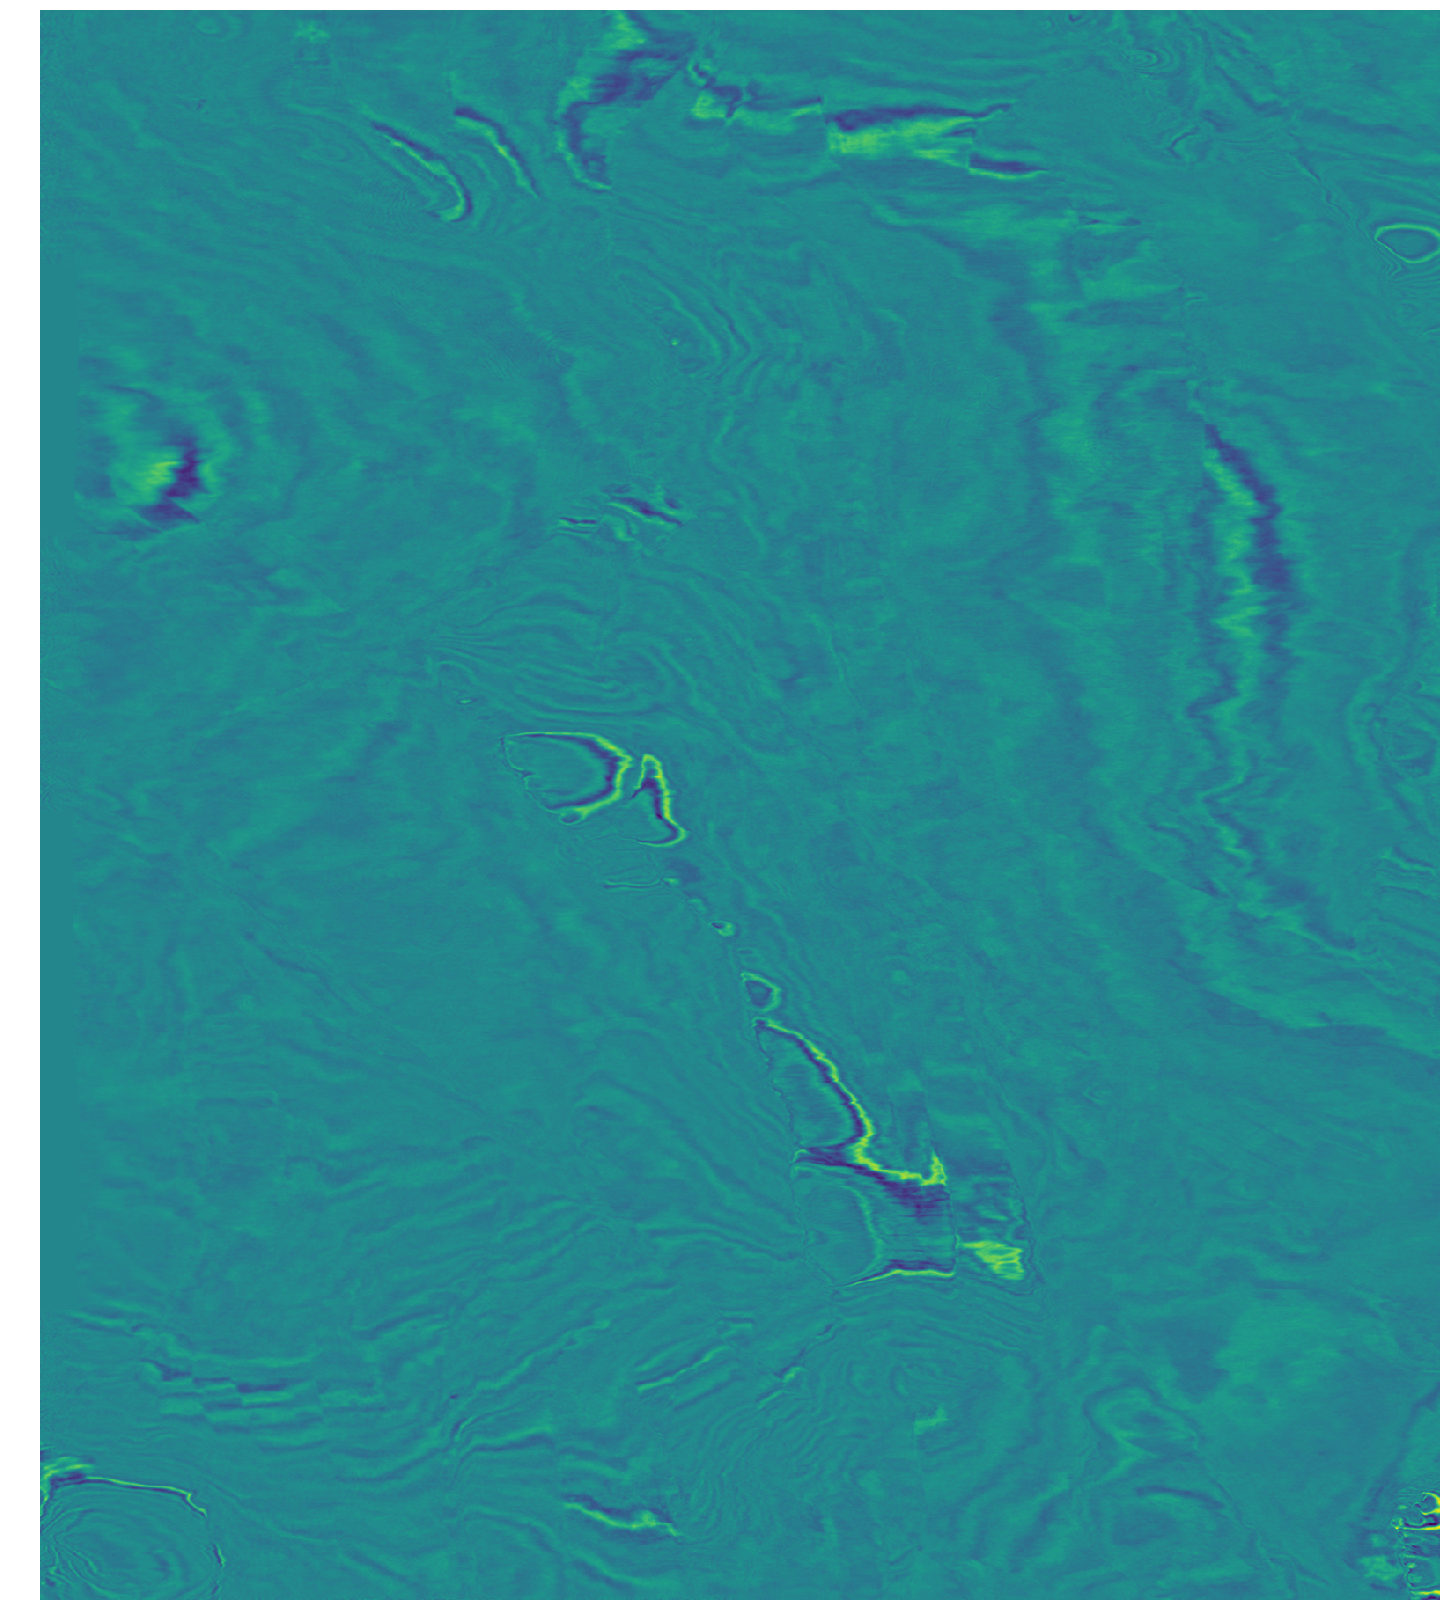

In [38]:
# https://stackoverflow.com/questions/13714454/specifying-and-saving-a-figure-with-exact-size-in-pixels
# im_np = numpy.random.rand(h, w)
im_np = seis[1000]
fig = plt.figure(frameon=False)
DPI = fig.get_dpi()
fig.set_size_inches(1807.0/float(DPI),1590.0/float(DPI))
# fig.set_size_inches(1807,1590)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
# ax.imshow(im_np, aspect='normal')
ax.imshow(im_np)
fig.savefig('figure.png', dpi=1)

In [45]:
# im_np = numpy.random.rand(h, w)
print(seis.shape)
seisil=np.moveaxis(seis,0,-1)
print(seisil.shape)

im_np = seisil[1]
fig = plt.figure(frameon=False)
DPI = fig.get_dpi()
print(DPI)
# fig.set_size_inches(1807.0/float(DPI),1590.0/float(DPI))
# # fig.set_size_inches(1807,1590)
# ax = plt.Axes(fig, [0., 0., 1., 1.])
# ax.set_axis_off()
# fig.add_axes(ax)
# # ax.imshow(im_np, aspect='normal')
# ax.imshow(im_np, cmap='seismic')
# fig.savefig('il.png')

(1537, 1807, 1590)
(1807, 1590, 1537)
72.0


<Figure size 432x288 with 0 Axes>

In [34]:
def plot3dseis(seis,d1,d2,d3,d1_sel=None,d2_sel=None,d3_sel=None,id1='Z',id2='IL',id3='XL',cm='seismic'):
    '''
    plot3dseis (C) aadm 2016
    Plot inline, crossline or horizontal (time/depth) slice from 3D seismic volume.
    INPUT
    seis:        3D seismic cube numpy array, shape (a,b,c);
                 usually this will be (twt.size, inl.size, crl.size)
    d1, d2, d3:  numpy array containing the range of first, second and third dimension in the cube;
                 usually d1=twt, d2=inl, d3=crl are defined beforehand,
                 e.g. inl=np.arange(1000,2000,4)
    d1_sel, ...: to select one horizontal slice, one inline or on crossline
                 e.g., d2_sel=1500 to plot IL 1500 (if d2=inl); only set one, the others must be None
    id1, ...:    names for first, second, third dimensions
    cmap:        colormap to use (choose one of the matplotlib colormaps)
    '''

    if (d1_sel is None) & (d2_sel is None) & (d3_sel is None):
        d2_sel = d2[int(d2.size/2)]
    if d1_sel is not None:
        ssplot=seis[d1.tolist().index(d1_sel),:,:]
        nome1,nome2,nomex,nomey = id1,str(d1_sel),id2,id3
        xleft,xrite = d2.min(),d2.max()
        ytop,ybot   = d3.min(),d3.max()
        plt.figure(figsize=(1807, 1590), dpi=1)
    if d2_sel is not None:
        ssplot=seis[:,d2.tolist().index(d2_sel),:]
        nome1,nome2,nomex,nomey = id2,str(d2_sel),id3,id1
        xleft,xrite = d3.min(),d3.max()
        ytop,ybot   = d1.min(),d1.max()
        plt.figure(figsize=(1537, 1590), dpi=1)
    if d3_sel is not None:
        ssplot=seis[:,:,d3.tolist().index(d3_sel)]
        nome1,nome2,nomex,nomey = id3,str(d3_sel),id2,id1
        xleft,xrite = d2.min(),d2.max()
        ytop,ybot   = d1.min(),d1.max()
        plt.figure(figsize=(1537, 1807), dpi=1)

    print('input 3D dimensions: {}'.format(seis.shape))
    print('{0}: {1}-{2}'.format(id1, d1.min(), d1.max()))
    print('{0}: {1}-{2}'.format(id2, d2.min(), d2.max()))
    print('{0}: {1}-{2}'.format(id3, d3.min(), d3.max()))
    print('dataset to plot dimensions: {}'.format(ssplot.shape))

#     plt.figure(figsize=(10,8))
    plt.imshow(ssplot,extent=[xleft,xrite,ybot,ytop],aspect='auto',cmap=cm)
    plt.colorbar(shrink=0.75), plt.grid()
    plt.tick_params(axis='both', which='major', labelsize=8)
    plt.title(nome1+' '+nome2)
    plt.xlabel(nomex), plt.ylabel(nomey)
    #plt.ylim(15000,0),plt.clim(-150,150)
    plt.show()
    plt.savefig('{}.png'.format(nome1+' '+nome2), dpi=1)

# #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
plot3dseis(seis,z,inl,crl,d1_sel=None,d2_sel=1002,d3_sel=None,id1='depth [m]',id2='IL',id3='XL')
# plt.ylim(15000,0),plt.clim(-150,150)
# plt.show()

input 3D dimensions: (1537, 1807, 1590)
depth [m]: 0-4608
IL: 1001-2807
XL: 860-2449
dataset to plot dimensions: (1537, 1590)


RuntimeError: In set_size: Could not set the fontsize

<Figure size 1537x1590 with 2 Axes>

<Figure size 432x288 with 0 Axes>

In [26]:
print(z)

[   0    3    6 ... 4602 4605 4608]


input 3D dimensions: (1537, 1807, 1590)
depth [m]: 0-4608
IL: 1001-2807
XL: 860-2449
dataset to plot dimensions: (1807, 1590)


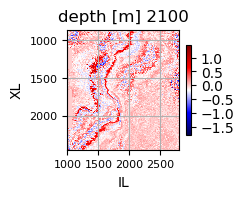

<Figure size 432x288 with 0 Axes>

In [30]:
plot3dseis(seis,z,inl,crl,d1_sel=2100,d2_sel=None,d3_sel=None,id1='depth [m]',id2='IL',id3='XL')

input 3D dimensions: (1537, 1807, 1590)
depth [m]: 0-4608
IL: 1001-2807
XL: 860-2449
dataset to plot dimensions: (1537, 1807)


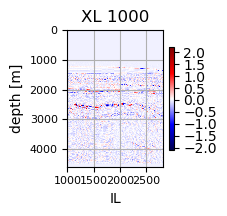

<Figure size 432x288 with 0 Axes>

In [31]:
plot3dseis(seis,z,inl,crl,d1_sel=None,d2_sel=None,d3_sel=1000,id1='depth [m]',id2='IL',id3='XL')